In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import brute 
plt.style.use("seaborn")

In [25]:
class EMABacktester:
    def __init__(self,symbol, EMA_S, EMA_L, start, end):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.start = start
        self.end = end 
        self.results = None
        self.get_data()
    
    def get_data(self):
        raw = pd.read_csv("/Users/kyungyunlee/Desktop/PYTHON_FOLDER/PYTHON_UDEMY/HAGMANN_AL_TRADING_STRATEGY/Course_Materials/forex_pairs.csv", parse_dates=["Date"], index_col=["Date"])
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol : "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span=self.EMA_S, min_periods=self.EMA_S).mean()
        raw["EMA_L"] = raw["price"].ewm(span=self.EMA_L, min_periods=self.EMA_L).mean()
        self.data = raw
    
    def set_parameters(self, EMA_S = None, EMA_L = None):
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span=self.EMA_S, min_periods=self.EMA_S).mean()
        
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span=self.EMA_L, min_periods=self.EMA_L).mean()
            
    def test_strategy(self):
        data = self.data.dropna().copy()
        data["position"] = np.where(data["EMA_S"] > data["EMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        perf = data["cstrategy"].iloc[-1]
        outperf = perf - data["creturns"].iloc[-1]
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        if self.results is None:
            print("Run strategy function first!")
        else:
            title = "{} | SMA_S = {} | SMA_L = {}".format(self.symbol, self.EMA_S, self.EMA_L)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
    
    def update_and_run(self, EMA):
        self.set_parameters(int(EMA[0]), int(EMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA1_range, EMA2_range):
        opt = brute(self.update_and_run, (EMA1_range, EMA2_range))
        return opt, -self.update_and_run(opt)

In [26]:
tester = EMABacktester("EURUSD=X", 50, 200, "2004-01-01", "2015-12-31")

In [27]:
tester.set_parameters(22, 100)

In [28]:
tester.test_strategy()

(1.433922, 0.523056)

In [29]:
tester.results

,price,returns,EMA_S,EMA_L,position,strategy,creturns,cstrategy
Date,,,,,,,,
2004-05-20,1.195700,-0.003918,1.196332,1.216276,-1,0.003918,0.996090,1.003925
2004-05-21,1.202805,0.005924,1.196895,1.215969,-1,-0.005924,1.002009,0.997995
2004-05-24,1.199904,-0.002415,1.197157,1.215604,-1,0.002415,0.999592,1.000408
2004-05-25,1.210097,0.008459,1.198282,1.215480,-1,-0.008459,1.008084,0.991981
2004-05-26,1.211094,0.000823,1.199396,1.215381,-1,-0.000823,1.008914,0.991165
...,...,...,...,...,...,...,...,...
2015-12-25,1.096996,0.005557,1.087693,1.098734,-1,-0.005557,0.913864,1.429218
2015-12-28,1.096599,-0.000362,1.088467,1.098692,-1,0.000362,0.913533,1.429736
2015-12-29,1.097526,0.000845,1.089255,1.098669,-1,-0.000845,0.914305,1.428528


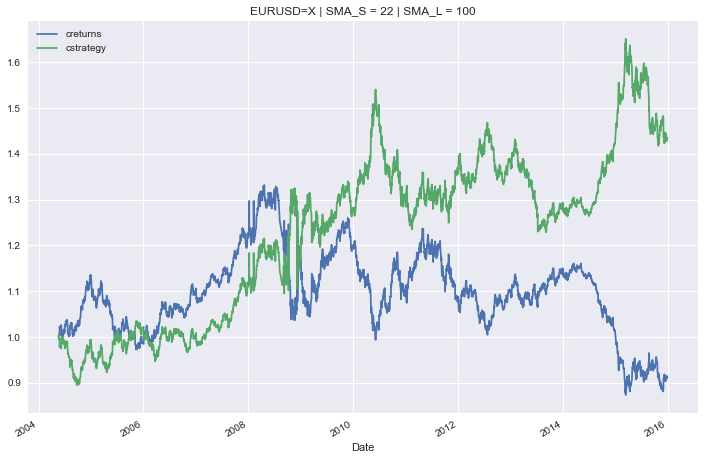

In [30]:
tester.plot_results()

In [31]:
((25, 75, 1), (100, 200, 1))

((25, 75, 1), (100, 200, 1))

In [32]:
tester.optimize_parameters((25, 75, 1), (100, 200, 1))

(array([ 36., 168.]), 1.650714)

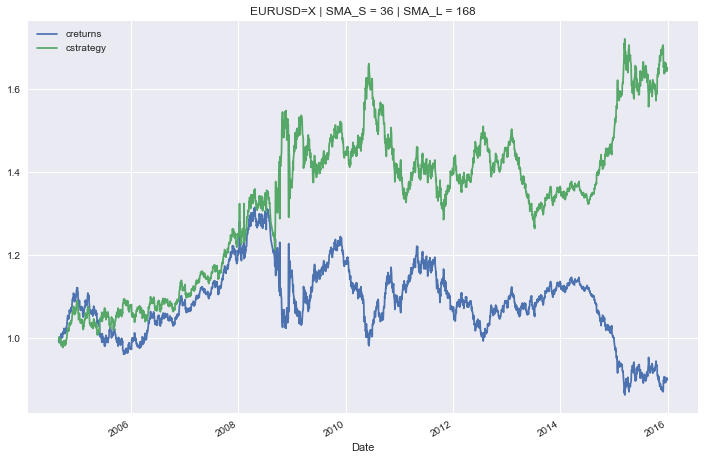

In [33]:
tester.plot_results()